### STEP 0: CONFIG & IMPORTS
#### Set your CSV path and targets here.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/datathon/Skill_Gap_Cleaned.csv"
CLASS_TARGET = "experience_level"   # classification target (categorical)
REG_TARGET   = "salary_usd"         # regression target (numeric)
RNG          = 42                   # reproducibility
a
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score, make_scorer
)

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    RandomForestRegressor, GradientBoostingRegressor
)

Mounted at /content/drive


Step 1 — Load Data & Quick Peek

In [ ]:
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

if CLASS_TARGET in df.columns:
    print("\nCLASS_TARGET value counts (top 10):")
    print(df[CLASS_TARGET].value_counts(dropna=False).head(10))

if REG_TARGET in df.columns:
    print("\nREG_TARGET describe():")
    print(df[REG_TARGET].describe())


Shape: (30038, 22)
Columns: ['name', 'job_title', 'salary_usd', 'salary_currency', 'salary', 'experience_level', 'employment_type', 'company_location', 'company_size', 'employee_residence', 'remote_ratio', 'required_skills', 'education_required', 'years_experience', 'industry', 'posting_date', 'application_deadline', 'job_description_length', 'benefits_score', 'company_name', 'age', 'skills']

CLASS_TARGET value counts (top 10):
experience_level
Senior       14423
Mid-level    14347
Executive     1268
Name: count, dtype: int64

REG_TARGET describe():
count     30038.00000
mean     100204.49639
std       47871.96248
min         346.26940
25%       68504.50000
50%       90428.00000
75%      114357.75000
max      399095.00000
Name: salary_usd, dtype: float64


Step 2 — Preprocessor Factory (Leakage-safe)

In [ ]:
# =====================================================
# STEP 2: PREPROCESSOR FACTORY (version-safe + rare-bucket)
# =====================================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def build_preprocessor(X, ohe_min_freq=None, scale_numeric=False) -> ColumnTransformer:
    """
    Leakage-safe ColumnTransformer:
      - Numeric: median impute (+ optional StandardScaler)
      - Categorical: most-frequent impute + One-Hot (ignore unknowns)
    Compatible with sklearn <1.2 (sparse=) and >=1.2 (sparse_output=).
    If your sklearn supports it, `ohe_min_freq` collapses rare categories to shrink width.
      - int  -> minimum count
      - float-> minimum proportion (e.g., 0.01 = 1%)
    """
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    num_steps = [("imp", SimpleImputer(strategy="median"))]
    if scale_numeric:
        # keep with_mean=False to remain sparse-friendly when combined with OHE
        num_steps.append(("scaler", StandardScaler(with_mean=False)))
    num_pipe = Pipeline(num_steps)

    # Version-safe OneHotEncoder with graceful fallback
    try:
        # Newer sklearn (>=1.2) uses sparse_output; (>=1.1) supports min_frequency
        ohe_kwargs = dict(handle_unknown="ignore", sparse_output=True)
        if ohe_min_freq is not None:
            ohe_kwargs["min_frequency"] = ohe_min_freq
        ohe = OneHotEncoder(**ohe_kwargs)
    except TypeError:
        # Older sklearn: no sparse_output / min_frequency
        # We silently drop min_frequency if unsupported
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ])

    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop"
    )


Step 3 — Classification: Train/Val Split & Cross-Validated Model Comparison

In [ ]:
if CLASS_TARGET not in df.columns:
    raise ValueError(f"Classification target '{CLASS_TARGET}' not found in dataset.")

# Drop rows with NA in classification target
df_cls = df.dropna(subset=[CLASS_TARGET]).copy()

Xc = df_cls.drop(columns=[CLASS_TARGET])
yc_raw = df_cls[CLASS_TARGET]

# Map labels to codes (and keep readable labels)
class_labels = None
if yc_raw.dtype == "O":
    yc_cat = yc_raw.astype("category")
    class_labels = list(yc_cat.cat.categories)
    yc = yc_cat.cat.codes
else:
    yc = yc_raw.copy()
    class_labels = [str(c) for c in sorted(pd.Series(yc).unique())]

# Stratified split to preserve class balance
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=RNG, stratify=yc
)

preproc_c = build_preprocessor(Xc_train)

clf_models = {
    "DummyMajority": DummyClassifier(strategy="most_frequent"),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=RNG),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RNG, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=RNG),
}

scorers_c = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "roc_auc_ovr": make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")
}

cv_c = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

rows = []
for name, est in clf_models.items():
    pipe = Pipeline([("preproc", preproc_c), ("model", est)])
    res = cross_validate(pipe, Xc_train, yc_train, cv=cv_c, scoring=scorers_c, n_jobs=-1)
    row = {"model": name}
    for k, v in res.items():
        if k.startswith("test_"):
            m = k.replace("test_", "")
            row[f"{m}_mean"] = np.mean(v)
            row[f"{m}_std"]  = np.std(v)
    rows.append(row)

clf_results = pd.DataFrame(rows).sort_values("f1_macro_mean", ascending=False)
print("=== Classification CV Results (sorted by F1-macro) ===")
display(clf_results.round(4))


=== Classification CV Results (sorted by F1-macro) ===


,model,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std,roc_auc_ovr_mean,roc_auc_ovr_std
2,DecisionTree,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,NaN,NaN
4,GradientBoosting,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,NaN,NaN
3,RandomForest,0.9995,0.0002,0.9980,0.0011,0.9997,0.0002,0.9964,0.0019,NaN,NaN
1,LogisticRegression,0.6467,0.0111,0.4404,0.0075,0.4340,0.0079,0.4501,0.0077,NaN,NaN
0,DummyMajority,0.4801,0.0001,0.2163,0.0000,0.1600,0.0000,0.3333,0.0000,NaN,NaN


Step 4 — Classification: Fit Best & Test Evaluation (Confusion Matrix)

Best model: DecisionTree
Accuracy:  1.0000
F1-macro:  1.0000
Precision: 1.0000
Recall:    1.0000
ROC-AUC:   1.0000


<Figure size 640x480 with 0 Axes>

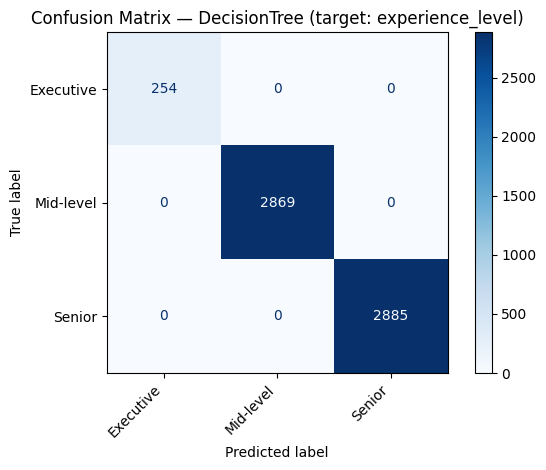

In [ ]:
best_clf_name = clf_results.iloc[0]["model"]
model_map = {
    "DummyMajority": DummyClassifier(strategy="most_frequent"),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=RNG),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RNG, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=RNG),
}
best_clf = model_map[best_clf_name]

final_clf = Pipeline([("preproc", preproc_c), ("model", best_clf)])
final_clf.fit(Xc_train, yc_train)

yc_pred = final_clf.predict(Xc_test)

# Optional ROC-AUC if proba available
try:
    yc_proba = final_clf.predict_proba(Xc_test)
    if len(np.unique(yc_train)) > 2:
        test_rocauc = roc_auc_score(yc_test, yc_proba, multi_class="ovr")
    else:
        test_rocauc = roc_auc_score(yc_test, yc_proba[:, 1])
except Exception:
    test_rocauc = np.nan

test_acc   = accuracy_score(yc_test, yc_pred)
test_f1m   = f1_score(yc_test, yc_pred, average="macro", zero_division=0)
test_precm = precision_score(yc_test, yc_pred, average="macro", zero_division=0)
test_recm  = recall_score(yc_test, yc_pred, average="macro", zero_division=0)

print(f"Best model: {best_clf_name}")
print(f"Accuracy:  {test_acc:.4f}")
print(f"F1-macro:  {test_f1m:.4f}")
print(f"Precision: {test_precm:.4f}")
print(f"Recall:    {test_recm:.4f}")
print(f"ROC-AUC:   {test_rocauc:.4f}")

# Confusion Matrix with readable labels
cm = confusion_matrix(yc_test, yc_pred, labels=sorted(pd.Series(yc_train).unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure()
disp.plot(values_format="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_clf_name} (target: {CLASS_TARGET})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Step 5 — Regression: Log Decision & CV Comparison (positive MAE/RMSE display)

In [ ]:
# =====================================================
# STEP 5: REGRESSION — ULTRA-FAST CV COMPARISON (PATCHED)
# =====================================================
from sklearn.linear_model import SGDRegressor  # sparse-friendly, fast
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
import numpy as np

# ---- Version-safe RMSE helper (works on old/new sklearn) ----
def rmse_metric(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

if REG_TARGET not in df.columns:
    raise ValueError(f"Regression target '{REG_TARGET}' not found.")

# 1) Aggressive cap to speed things up (raise later when you're happy)
df_reg = df.dropna(subset=[REG_TARGET]).copy()
CAP = 8000  # try 5k–10k for quick iterations; bump later
if len(df_reg) > CAP:
    df_reg = df_reg.sample(n=CAP, random_state=RNG)

Xr = df_reg.drop(columns=[REG_TARGET])
yr = df_reg[REG_TARGET].astype(float)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=RNG
)

# 2) Preprocess with rare-category bucketing to keep OHE narrow
#    (build_preprocessor must be the version-safe one from Step 2)
preproc_r = build_preprocessor(Xr_train, ohe_min_freq=0.01)  # falls back safely if not supported

# 3) Decide log-transform by skewness (keeps errors sane when long-tailed)
skew = pd.Series(yr_train).dropna().skew()
USE_LOG = bool(skew > 1.0)
print(f"Target '{REG_TARGET}' skew: {skew:.3f} → log-transform = {USE_LOG}")

def wrap(reg):
    if USE_LOG:
        return TransformedTargetRegressor(regressor=reg, func=np.log1p, inverse_func=np.expm1)
    return reg

# 4) Sparse-friendly & fast models only
reg_models = {
    "Ridge": Ridge(alpha=1.0, random_state=RNG),
    "SGD_huber": SGDRegressor(loss="huber", penalty="l2", alpha=1e-4,
                              max_iter=2000, early_stopping=True, random_state=RNG),
}

# 5) Lean metrics + 2-fold CV (fast)
scorers_r = {
    "MAE":  make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(rmse_metric, greater_is_better=False),  # version-safe RMSE
    "R2":   "r2",
}
cv_r = KFold(n_splits=2, shuffle=True, random_state=RNG)  # 2-fold for speed

# 6) Run CV with progress prints; avoid nested parallelism
rows = []
for name, base in reg_models.items():
    print(f"[CV] Fitting {name} ...")
    est = wrap(base)
    pipe = Pipeline([("preproc", preproc_r), ("model", est)])
    res = cross_validate(pipe, Xr_train, yr_train, cv=cv_r, scoring=scorers_r,
                         n_jobs=1, return_train_score=False, verbose=0)
    row = {"model": name}
    for k, v in res.items():
        if k.startswith("test_"):
            m = k.replace("test_", "")
            row[f"{m}_mean"] = np.mean(v); row[f"{m}_std"] = np.std(v)
    rows.append(row)

reg_results = pd.DataFrame(rows)

# Flip signs so MAE/RMSE are positive magnitudes for readability
for col in ["MAE_mean", "MAE_std", "RMSE_mean", "RMSE_std"]:
    reg_results[col] = -reg_results[col]

reg_results = reg_results.sort_values("RMSE_mean", ascending=True)
print("=== Regression CV Results (2-fold, RMSE sorted; lower is better) ===")
display(reg_results.round(4))

# --- Optional sanity check: transformed width
print("\n[Sanity] Estimating transformed width ...")
_ = preproc_r.fit(Xr_train)
Xt_shape = preproc_r.transform(Xr_train[:100]).shape
print("Transformed sample shape (100 rows):", Xt_shape)


Target 'salary_usd' skew: 1.914 → log-transform = True
[CV] Fitting Ridge ...
[CV] Fitting SGD_huber ...
=== Regression CV Results (2-fold, RMSE sorted; lower is better) ===


,model,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std
0,Ridge,24556.2505,-391.8621,36261.1268,-30.4097,0.4292,0.0038
1,SGD_huber,NaN,NaN,NaN,NaN,NaN,NaN



[Sanity] Estimating transformed width ...
Transformed sample shape (100 rows): (100, 137)


In [ ]:
# ==== Compat helper for RMSE (works on all sklearn versions) ====
import numpy as np
from sklearn.metrics import mean_squared_error

def rmse_metric(y_true, y_pred):
    try:
        # Newer sklearn
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # Older sklearn fallback
        return np.sqrt(mean_squared_error(y_true, y_pred))


 STEP 6: REGRESSION — FIT BEST (FAST) & TEST  [PATCHED]


[Fit] Training final Ridge on full train split ...
Ridge  ->  MAE: 24821.5049 | RMSE: 36446.9337 | R^2: 0.4276


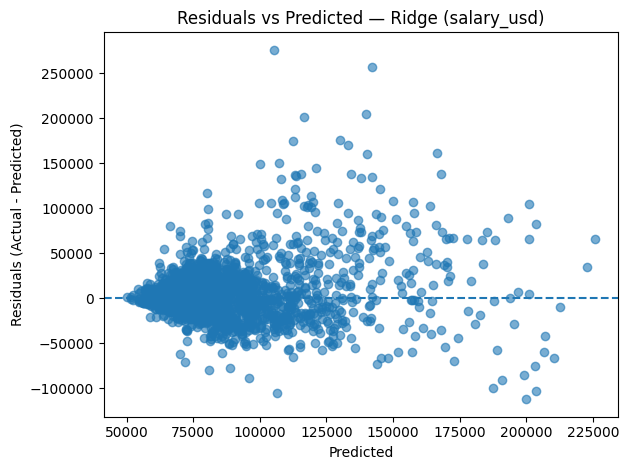

In [ ]:
best_reg_name = reg_results.iloc[0]["model"]
model_map_reg = {
    "Ridge": Ridge(alpha=1.0, random_state=RNG),
    "SGD_huber": SGDRegressor(loss="huber", penalty="l2", alpha=1e-4,
                              max_iter=2000, early_stopping=True, random_state=RNG),
}
best_reg = model_map_reg[best_reg_name]

final_reg = Pipeline([("preproc", preproc_r), ("model", wrap(best_reg))])
print(f"[Fit] Training final {best_reg_name} on full train split ...")
final_reg.fit(Xr_train, yr_train)

yr_pred = final_reg.predict(Xr_test)
mae  = mean_absolute_error(yr_test, yr_pred)
rmse = rmse_metric(yr_test, yr_pred)   # <= version-safe RMSE
r2   = r2_score(yr_test, yr_pred)

print(f"{best_reg_name}  ->  MAE: {mae:.4f} | RMSE: {rmse:.4f} | R^2: {r2:.4f}")

# Residuals
residuals = yr_test - yr_pred
plt.figure()
plt.scatter(yr_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residuals vs Predicted — {best_reg_name} ({REG_TARGET})")
plt.tight_layout(); plt.show()

Step 7 — (Optional) Save CV Tables

In [ ]:
from pathlib import Path
out_dir = Path("/content/drive/MyDrive/Colab Notebooks/datathon/03_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

clf_results.round(6).to_csv(out_dir / "classification_cv_results.csv", index=False)
reg_results.round(6).to_csv(out_dir / "regression_cv_results.csv", index=False)

print("Saved:")
print(" -", out_dir / "classification_cv_results.csv")
print(" -", out_dir / "regression_cv_results.csv")


Saved:
 - /content/drive/MyDrive/Colab Notebooks/datathon/03_outputs/classification_cv_results.csv
 - /content/drive/MyDrive/Colab Notebooks/datathon/03_outputs/regression_cv_results.csv


# we dropped salary_usd part because it isn't revelent
